# Using Ring Deconvolution Microscopy (RDM)

This is a notebook which will walk you through basics of rdmpy.

Interested in some background on these methods? Check out the [paper](https://arxiv.org/abs/2206.08928).

The data we use in this notebook comes from the [UCLA Miniscope](http://miniscope.org/index.php/Main_Page).

Refer to the other notebooks in the repository for replication of the experiments in the paper.


## Setup

Here we import some necessary packages/helper functions for the demo, including the star of the show: rdmpy

In [1]:
%load_ext autoreload
%autoreload 2
!export CUDA_VISIBLE_DEVICES=0,1,2,3 # REPLACE this line according to your GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" # REPLACE this line according to your GPUs

import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image

# Fill this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def center_crop(img, des_shape, center=None):
    if center is None:
        center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        center[1] - des_shape[1] // 2,
        center[1] + int(np.round(des_shape[1] / 2)),
        center[0] - des_shape[0] // 2,
        center[0] + int(np.round(des_shape[0] / 2)),
    )
    img = img[up:down, left:right]
    return img

def crop(img, c):
    return img[c:-c,c:-c]


Using cuda:3 for computation


/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## One-time Calibration

The first step in the RDM pipeline is to calibrate your microscope. This is very similar to measuring a point spread function for deconvolution. The only difference is now you take a single image of randomly-placed point sources. We visualize one such calibration image from the Miniscope in the cell below. 

In [2]:
dim = 512 # Pick this according to how big of an image you want to deblur. Reduce if memory errors.

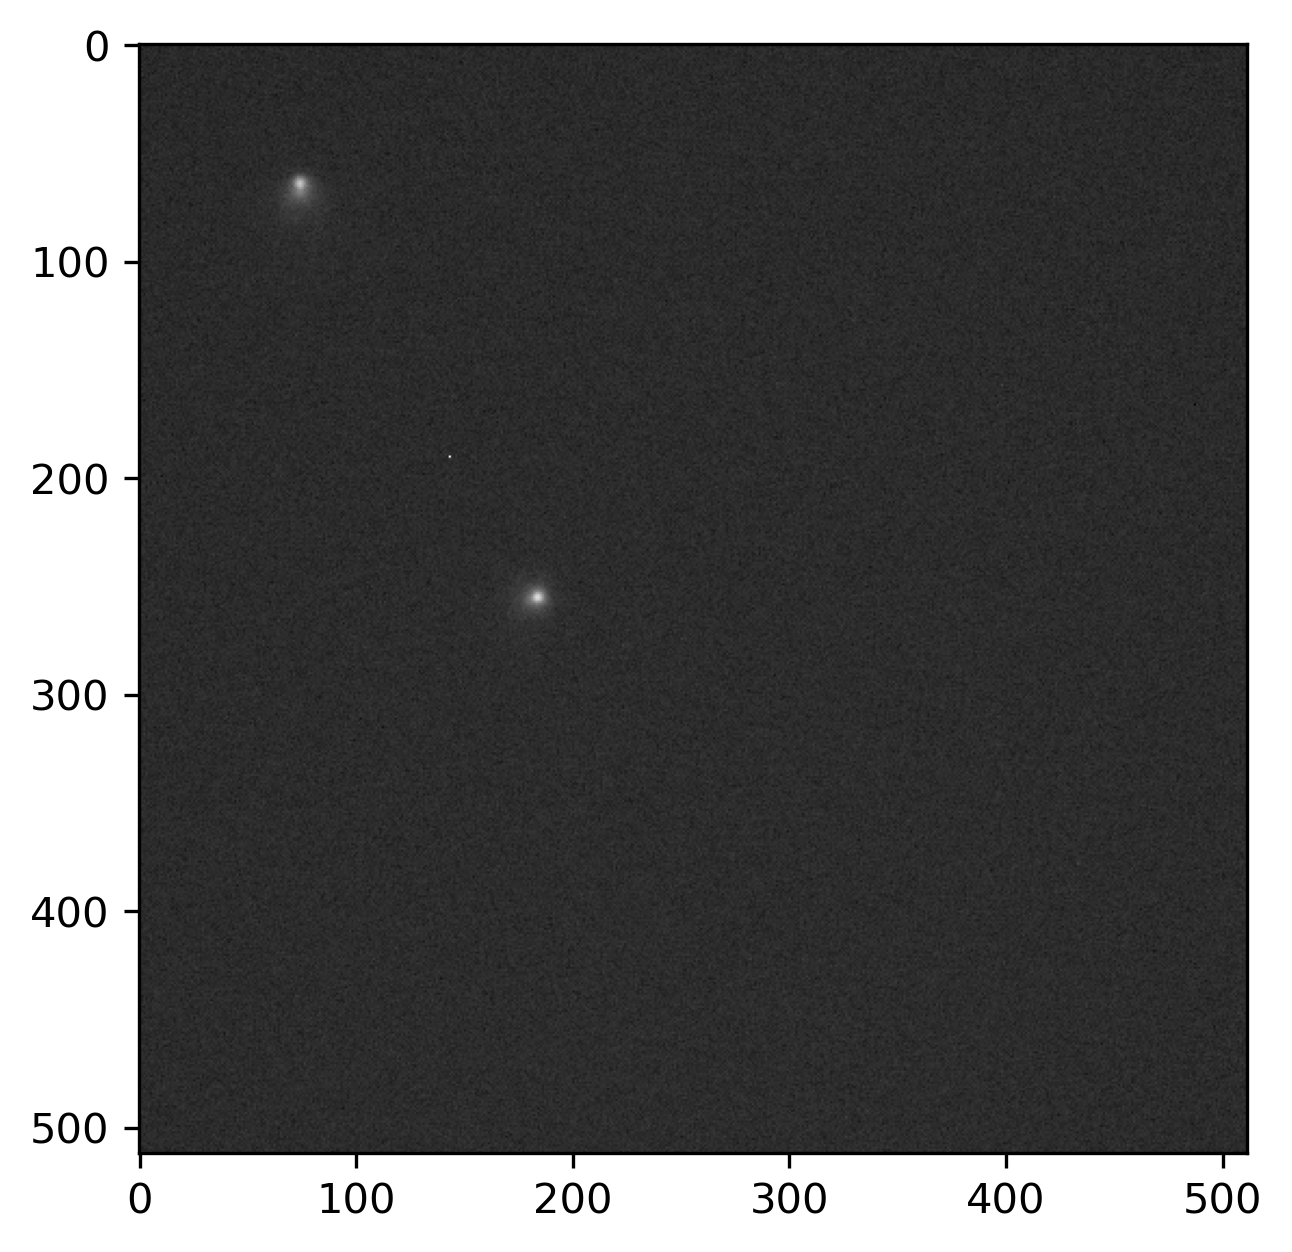

In [3]:
calibration_image = np.array(Image.open('test_images/calibration_image.tif'))
plt.imshow(center_crop(calibration_image**(1/2), [dim,dim]), cmap='gray')
plt.show()

To calibrate, just input this image into the `calibrate` function. This will give back Seidel coefficients and synthetic PSFs. These characterize the system and can be directly used to blur/deblur any image taken from the microscope.

fitting seidel coefficients...


100%|██████████| 300/300 [00:04<00:00, 67.00it/s]


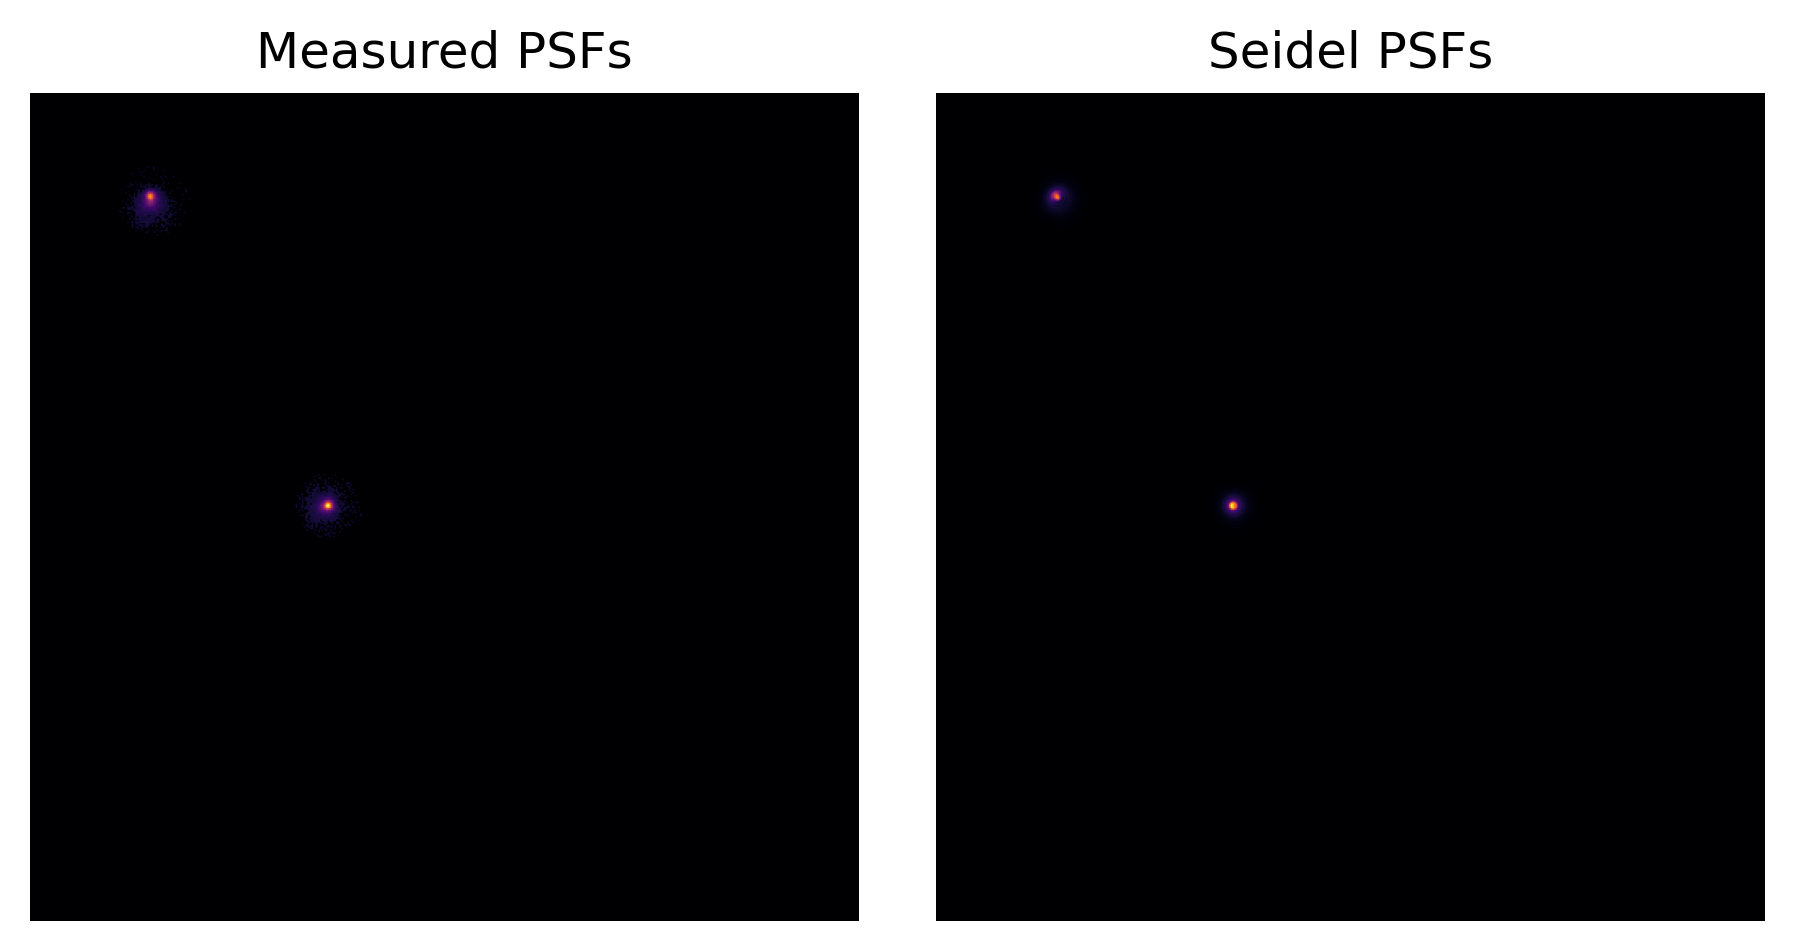

Fitted seidel coefficients: tensor([[0.9157],
        [0.3318],
        [0.0081],
        [0.2914],
        [0.0000],
        [0.0000]])


In [4]:
# sys_params = {"NA": 0.5}
seidel_coeffs = rdmpy.calibrate_rdm(calibration_image, dim=512, device=device, show_psfs=True, get_psfs=False)

## Simulating blur with ring convolution
Now that we have calibrated the system, we can simulate the spatially-varying blur using ring convolution. Normally this process would take over an hour, even for 512x512 image! Check out how fast it is with ring convolution. If you want to speed it up even more or reduce memory, try setting patch_size to something like 8 or 16.

In [ ]:
psf_data = rdmpy.get_rdm_psfs(seidel_coeffs, dim=dim, model='lri', device=device) #optional set patch_size=16


rendering PSFs...


100%|██████████| 512/512 [00:33<00:00, 15.45it/s]


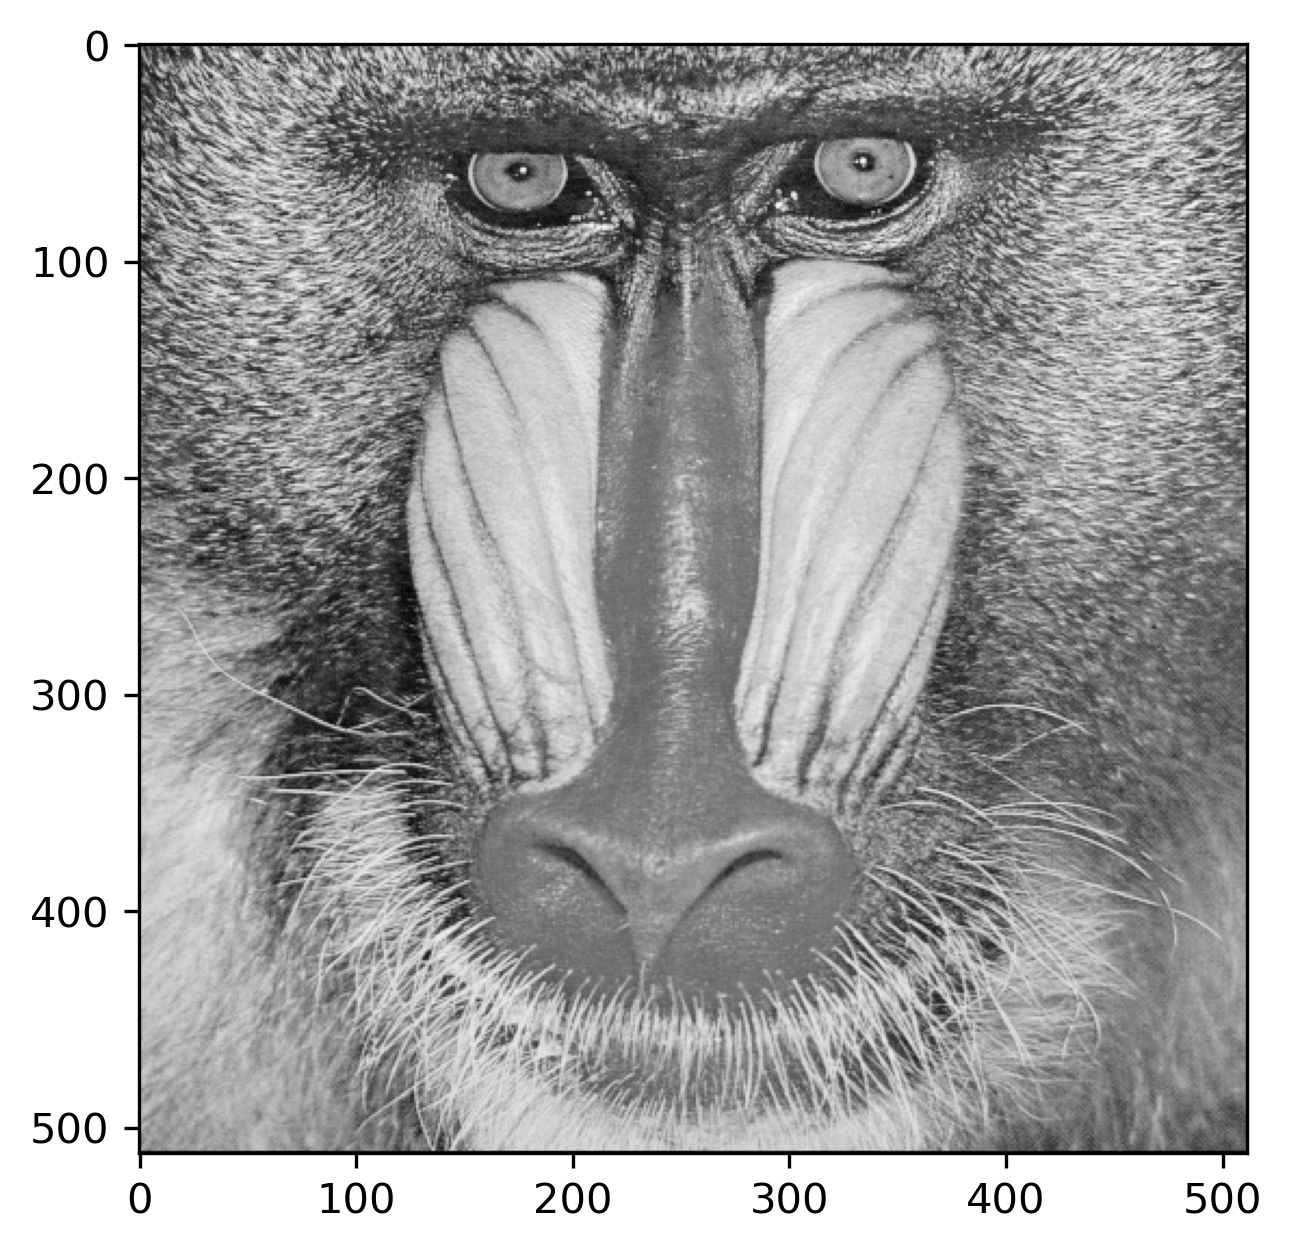

In [6]:
# Here is a test image
measurement = plt.imread('test_images/baboon.png')
measurement = measurement/measurement.max()
plt.imshow(measurement, cmap='gray')
plt.show()

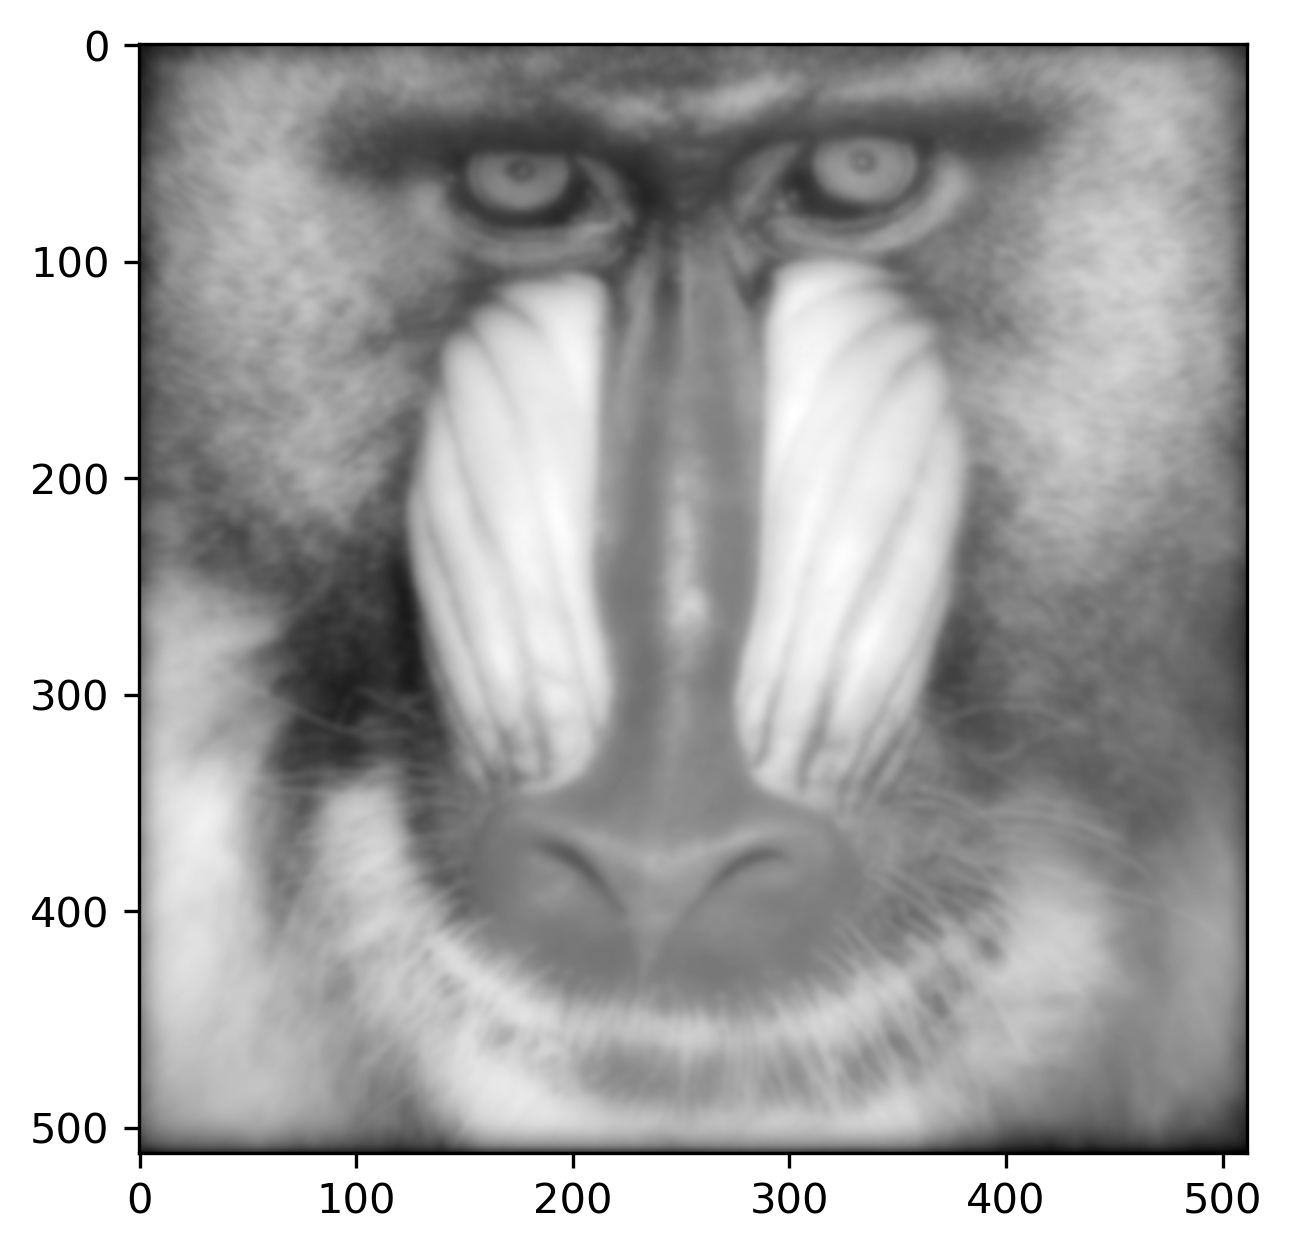

In [ ]:
# Now we blur it (and add some noise)
blurred = rdmpy.ring_convolve(measurement, psf_data, device=device).cpu() #optional set patch_size=16
blurred_noisy = blurred + np.random.normal(0, 1e-3,(dim,dim))
plt.imshow(blurred_noisy, cmap='gray')
plt.show()

## Deblurring time: Ring deconvolution
Now that we have a blurry, noisy measurement and the Seidel PSFs from the calibration procedure, we can run our main algorithm Ring deconvolution! 


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


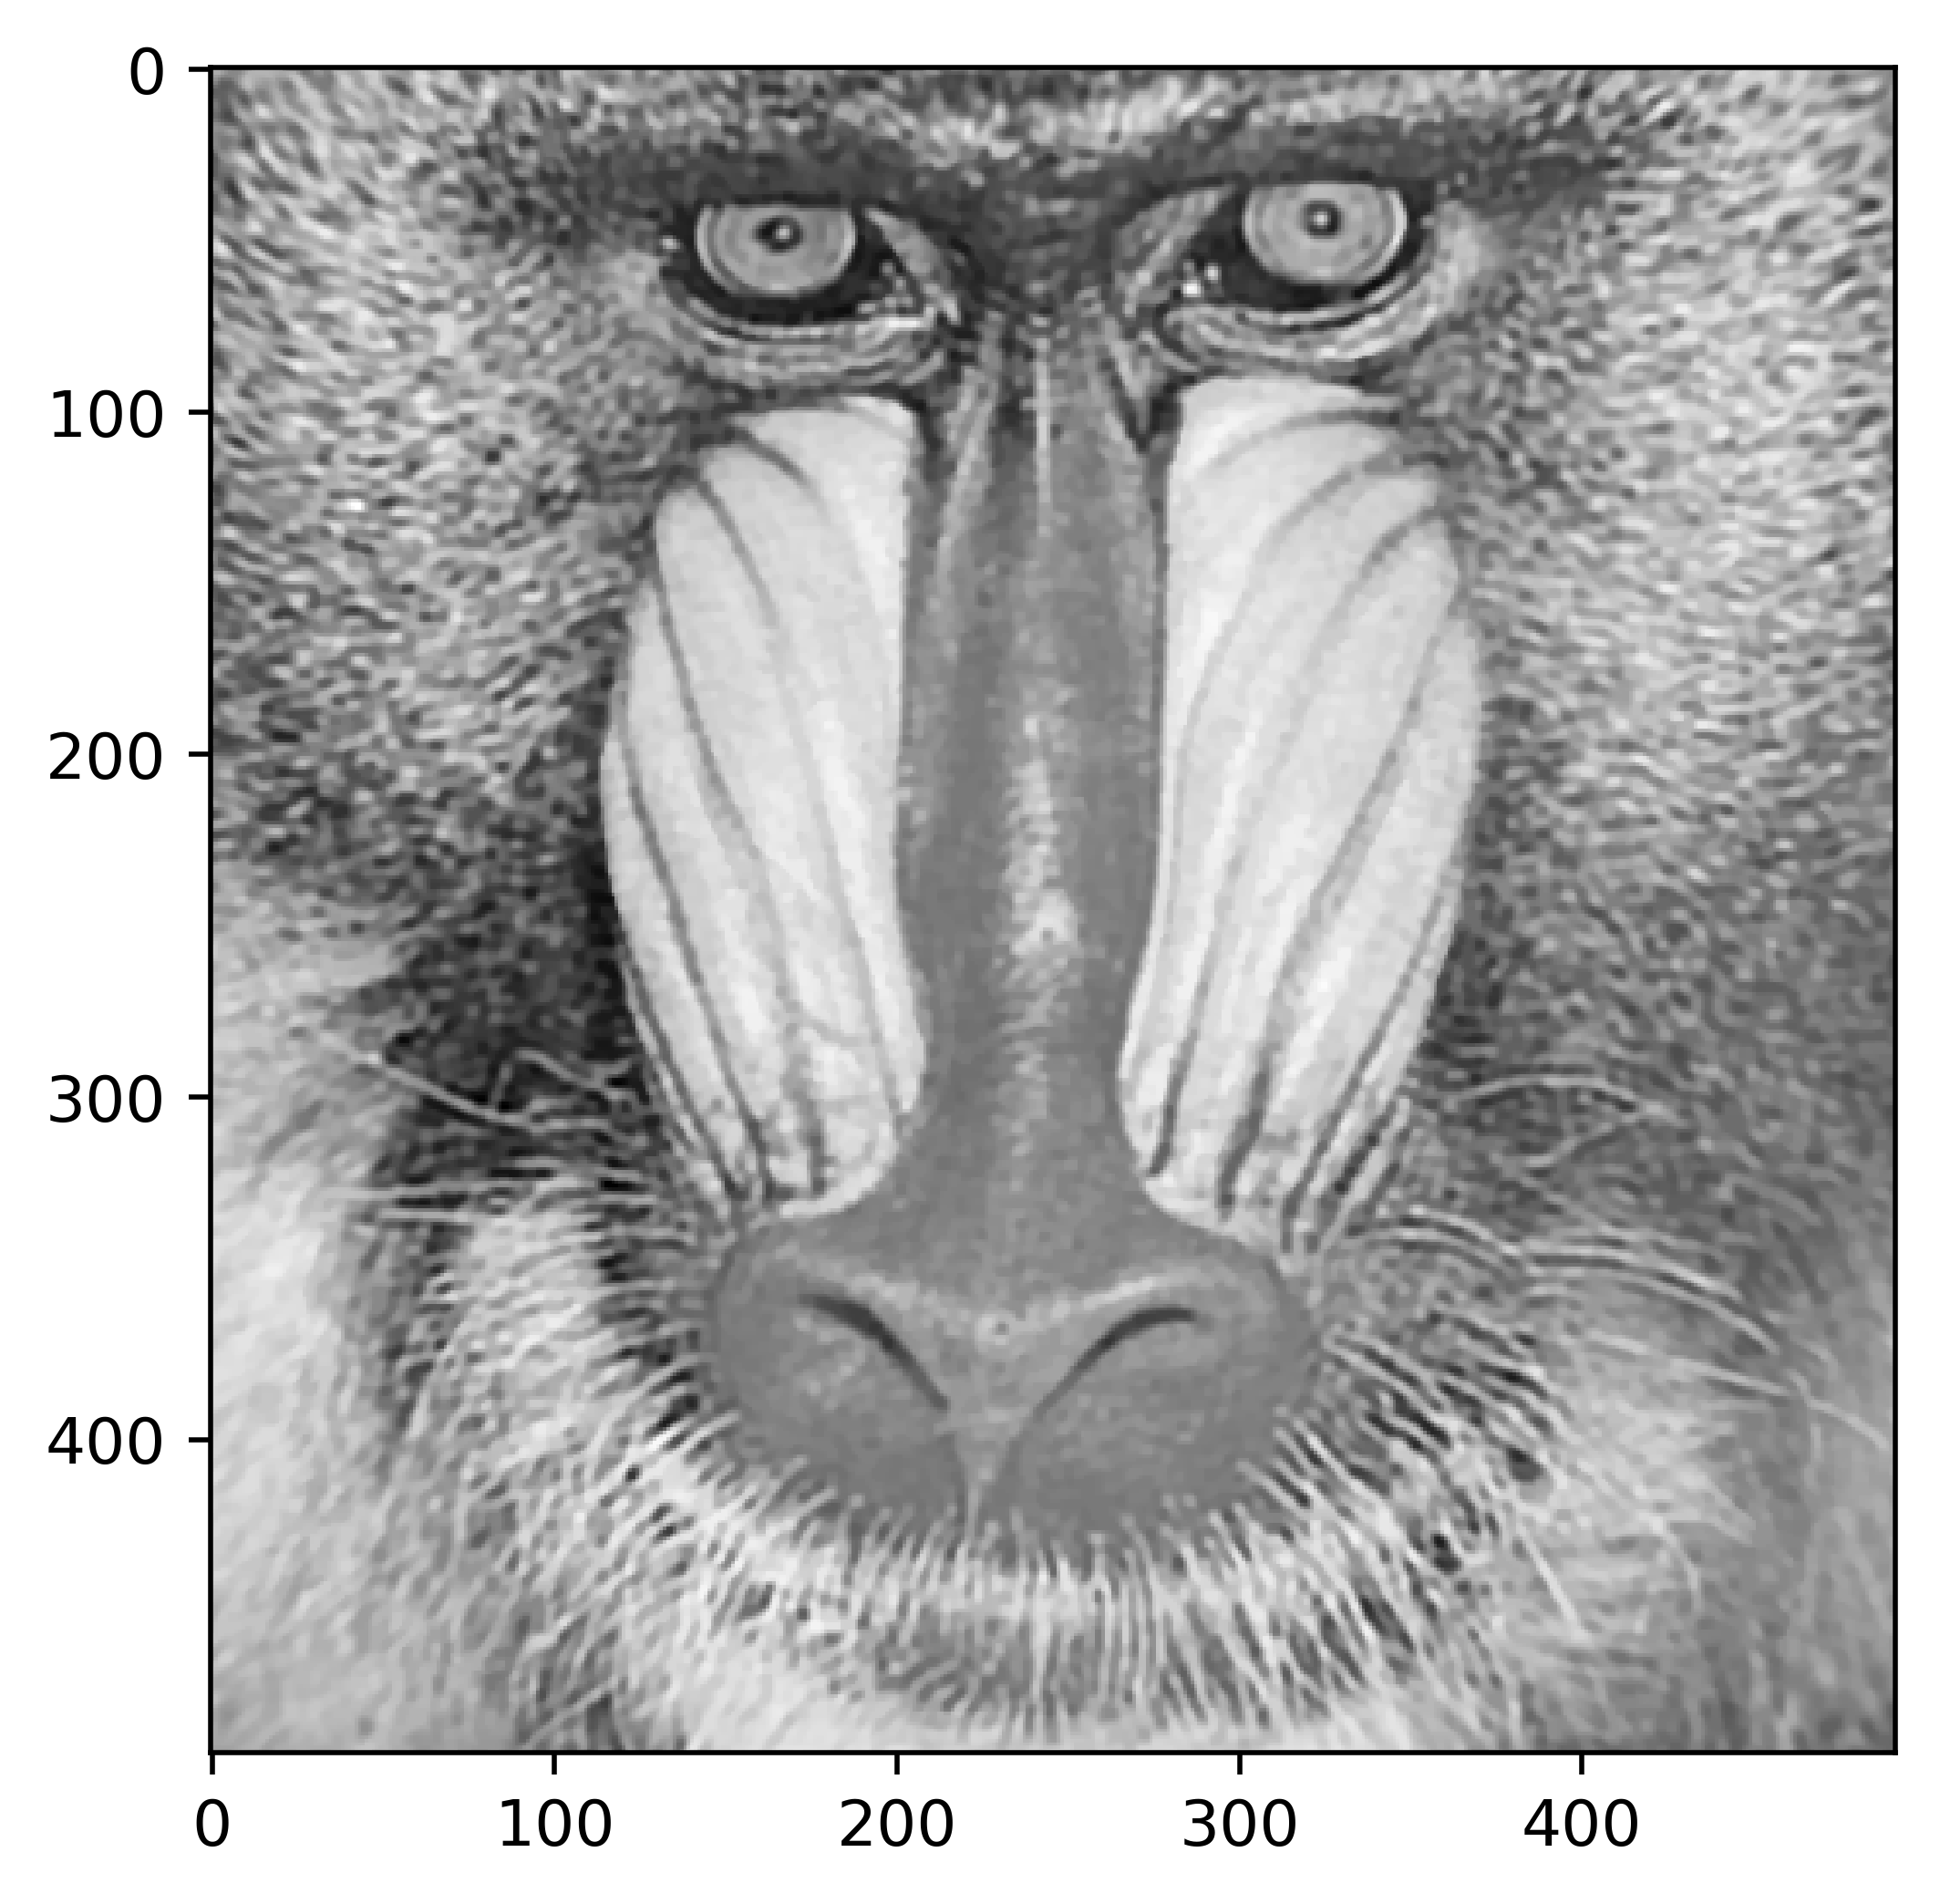

In [ ]:
#crop to get rid of edge artifacts caused by finite size PSF
c = 10

#now deblur with ring deconvolution
rd_recon = rdmpy.ring_deconvolve(blurred_noisy, psf_data, iters=150, device=device, process=False) #optional set patch_size=16

plt.imshow(crop(rd_recon,c), cmap='gray')
plt.show()

## Faster alternative: DeepRD

loading model...


/home/amit/projects/rdmpy/rdmpy/_src/util.py:679: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_type.load_state_dict(torch.load(model_path, map_location=device))


rendering PSFs...


100%|██████████| 1/1 [00:00<00:00, 218.52it/s]


deblurring...


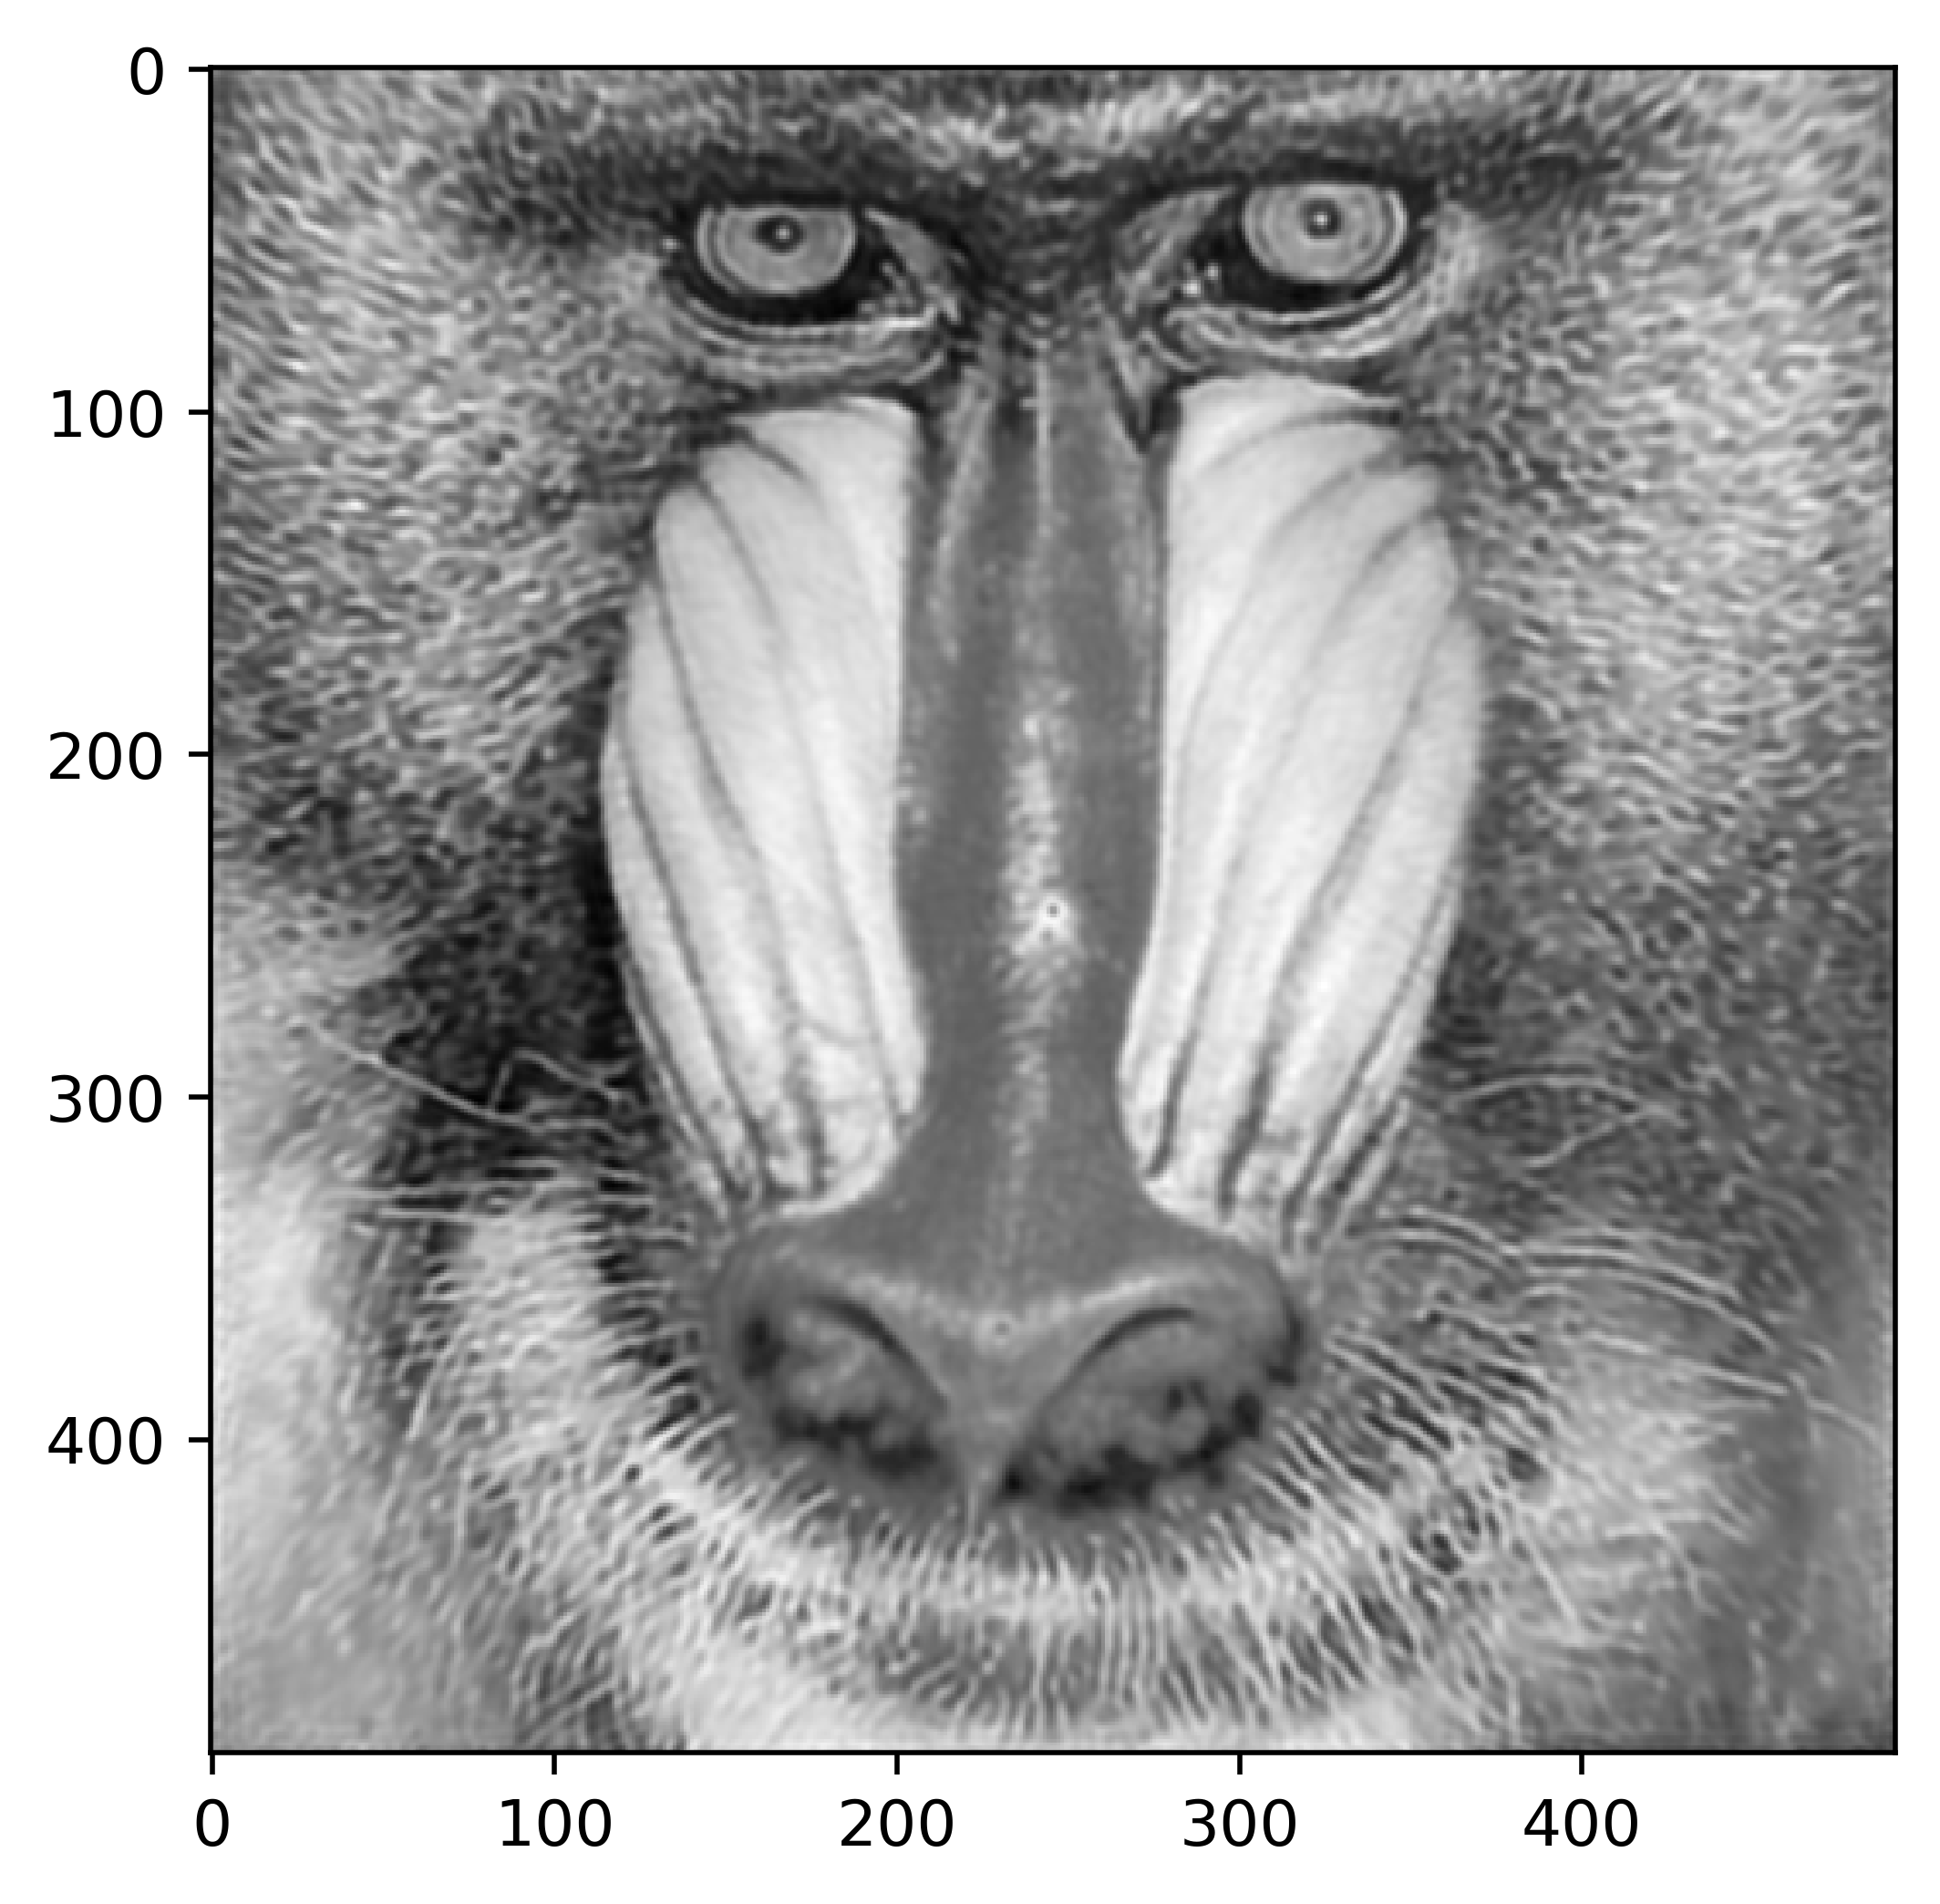

In [11]:
#Now with DeepRD, an even faster solution!
deeprd_recon = rdmpy.deeprd(blurred_noisy, seidel_coeffs, device=device, process=False)

plt.imshow(crop(deeprd_recon,c), cmap='gray')
plt.show()

## Alternative methods: Seidel deconvolution
Sometimes the system is sufficiently spatially-invariant. Even so RDM can help by using the synthetic Seidel PSFs for noiseless deconvolution. There is also a blind version!

rendering PSFs...


100%|██████████| 1/1 [00:00<00:00, 249.91it/s]

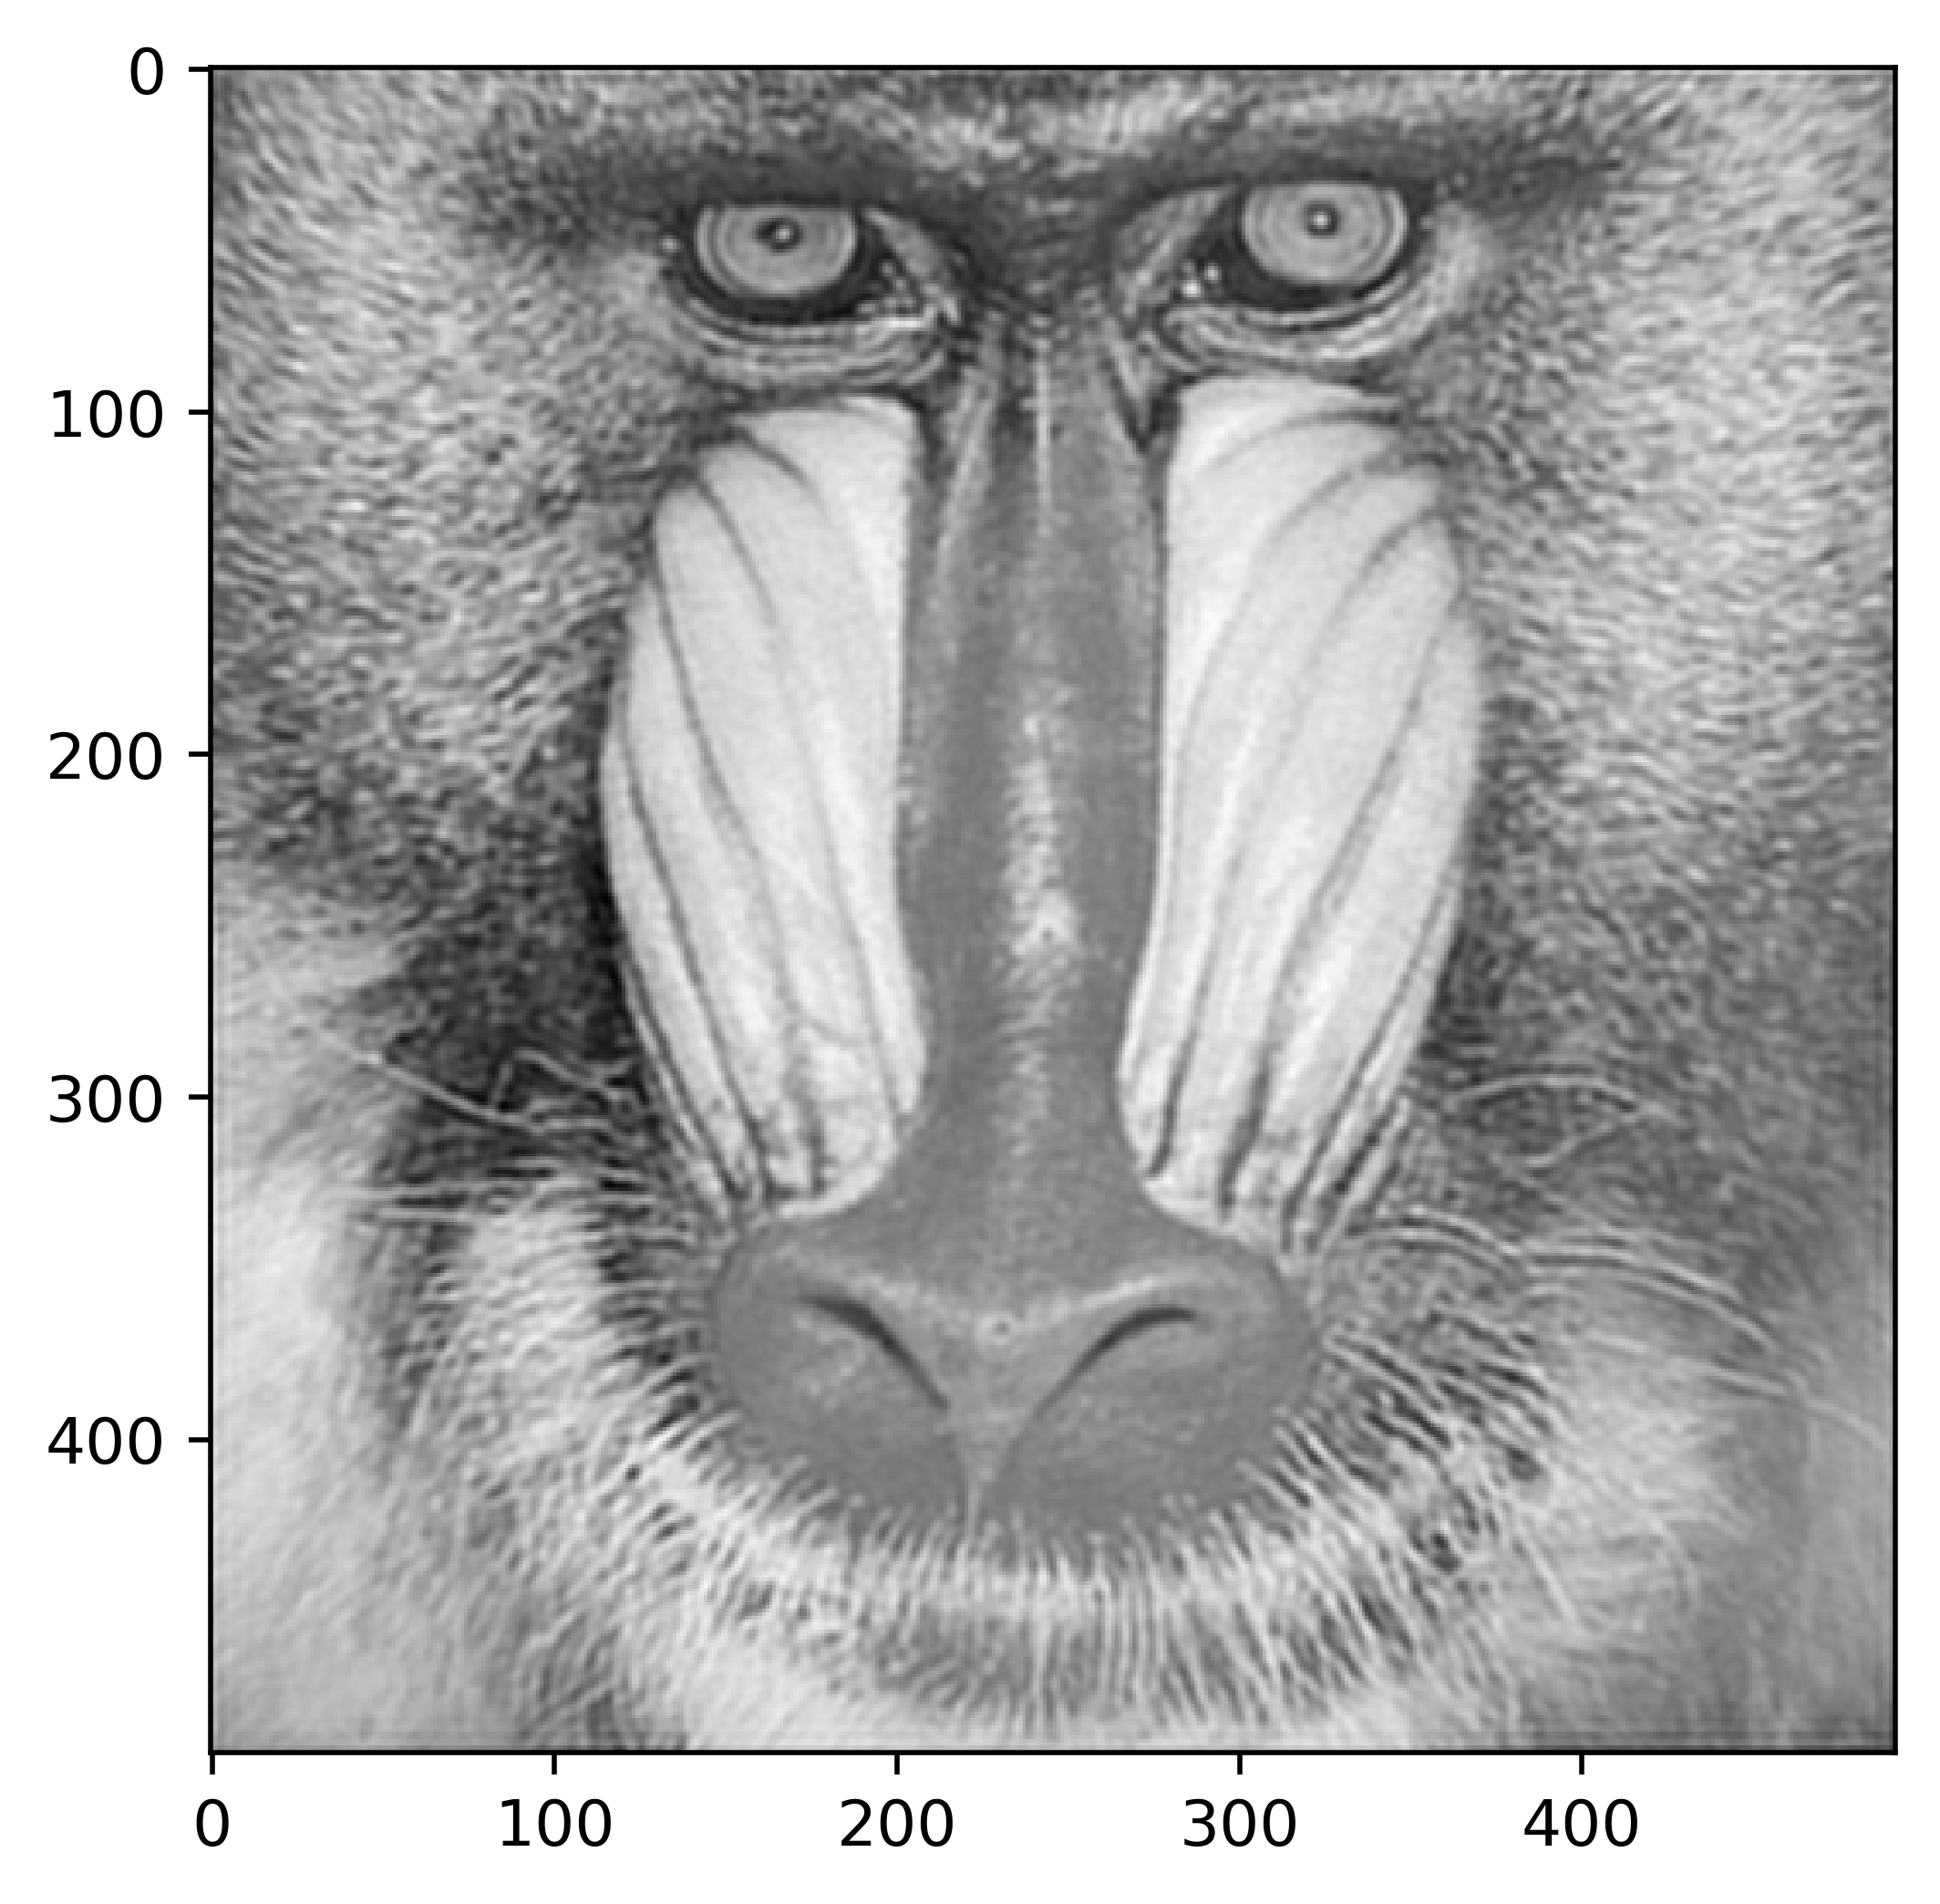

In [12]:
# First we get the center PSF from our fitted Seidel coefficients
center_psf = rdmpy.get_rdm_psfs(seidel_coeffs, dim, model='lsi', device=device)

# Now we can do standard deconvolution
deconv = rdmpy.deconvolve(blurred_noisy, center_psf, device=device, process=False)

plt.imshow(crop(deconv,c), cmap='gray')
plt.show()

## Alternate methods: Blind deconvolution
By co-optimizing the spherical Seidel coefficient with the reconstruction we can perform calibration-free deconvolution

100%|██████████| 100/100 [00:03<00:00, 28.64it/s]


Fitted seidel coefficient: tensor([0.8825])
Pretty close to the fitted coefficient:  tensor([0.9157])


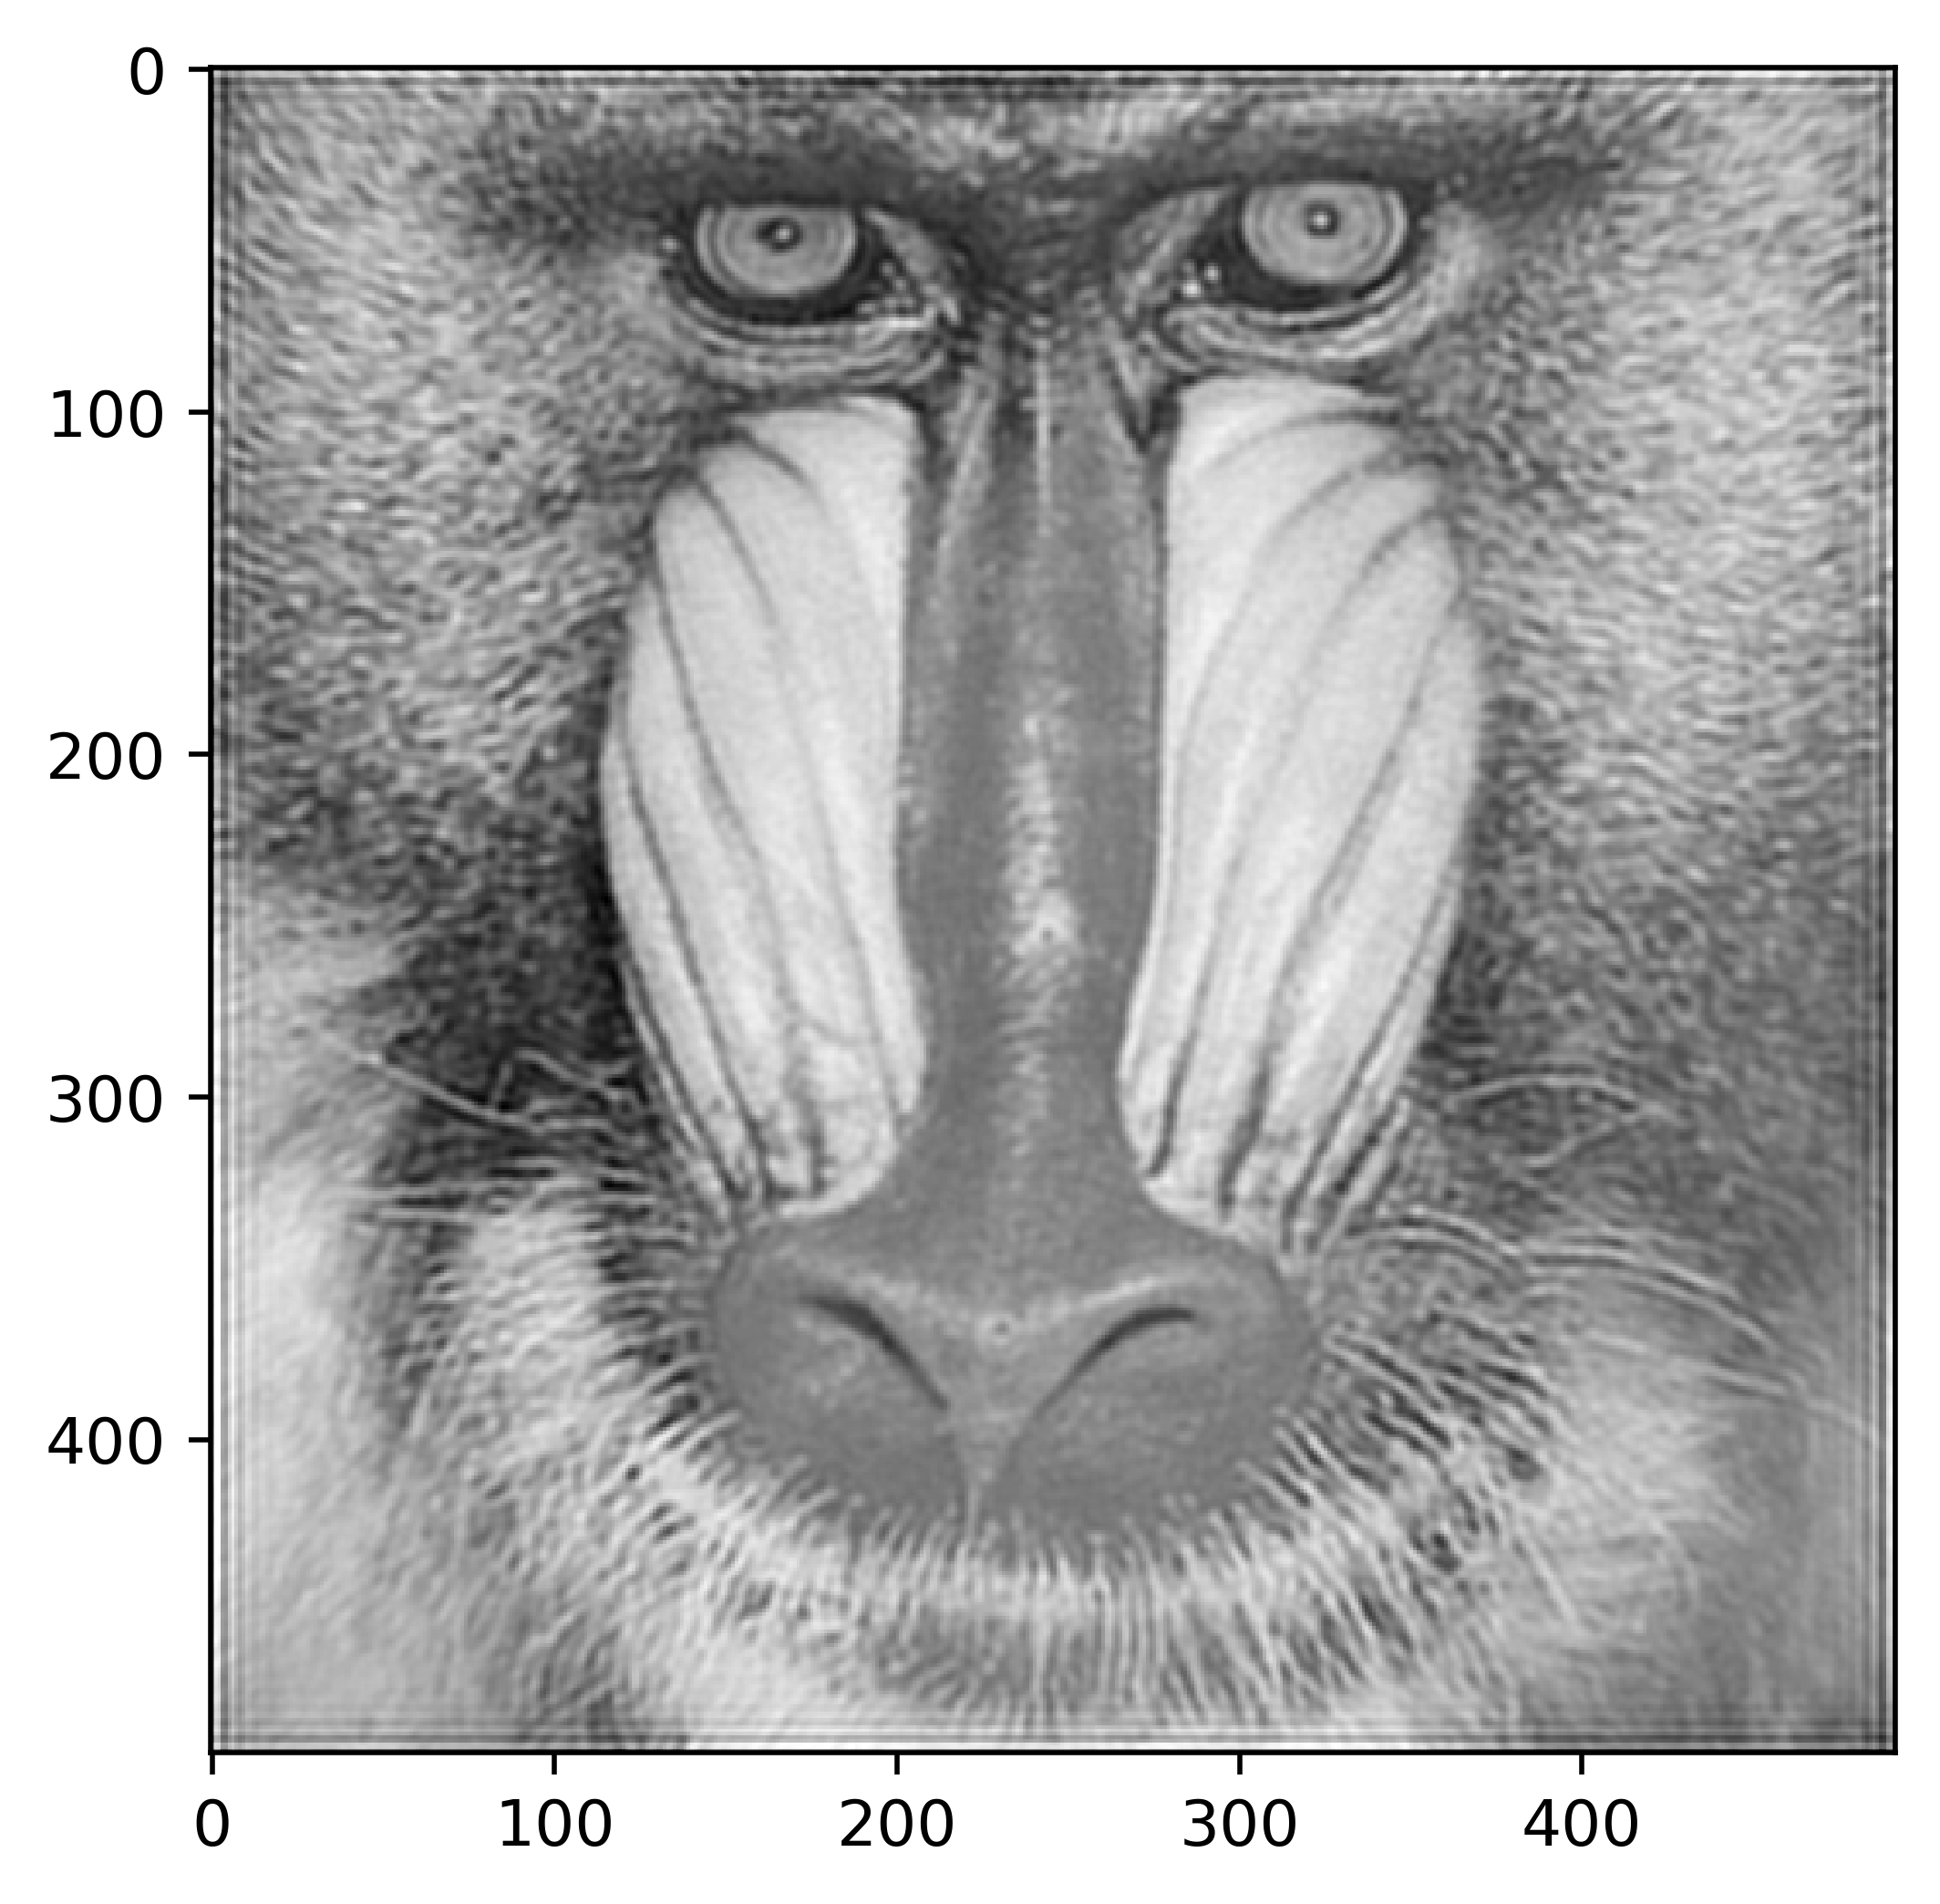

In [14]:
# note, we don't use the PSF data or Seidel coefficients; this method only requires a blurry image.
deconv_blind = rdmpy.blind(blurred_noisy, device=device, process=True)

print('Pretty close to the fitted coefficient: ', seidel_coeffs[0].cpu())

plt.imshow(crop(deconv_blind,c), cmap='gray')
plt.show()


## Some real data

Since we already fit the Seidel coefficients to the calibration image from the Miniscope, we may as well deblur some real data! To see the full resolution experiment, refer to the waterbear jupyter notebook.

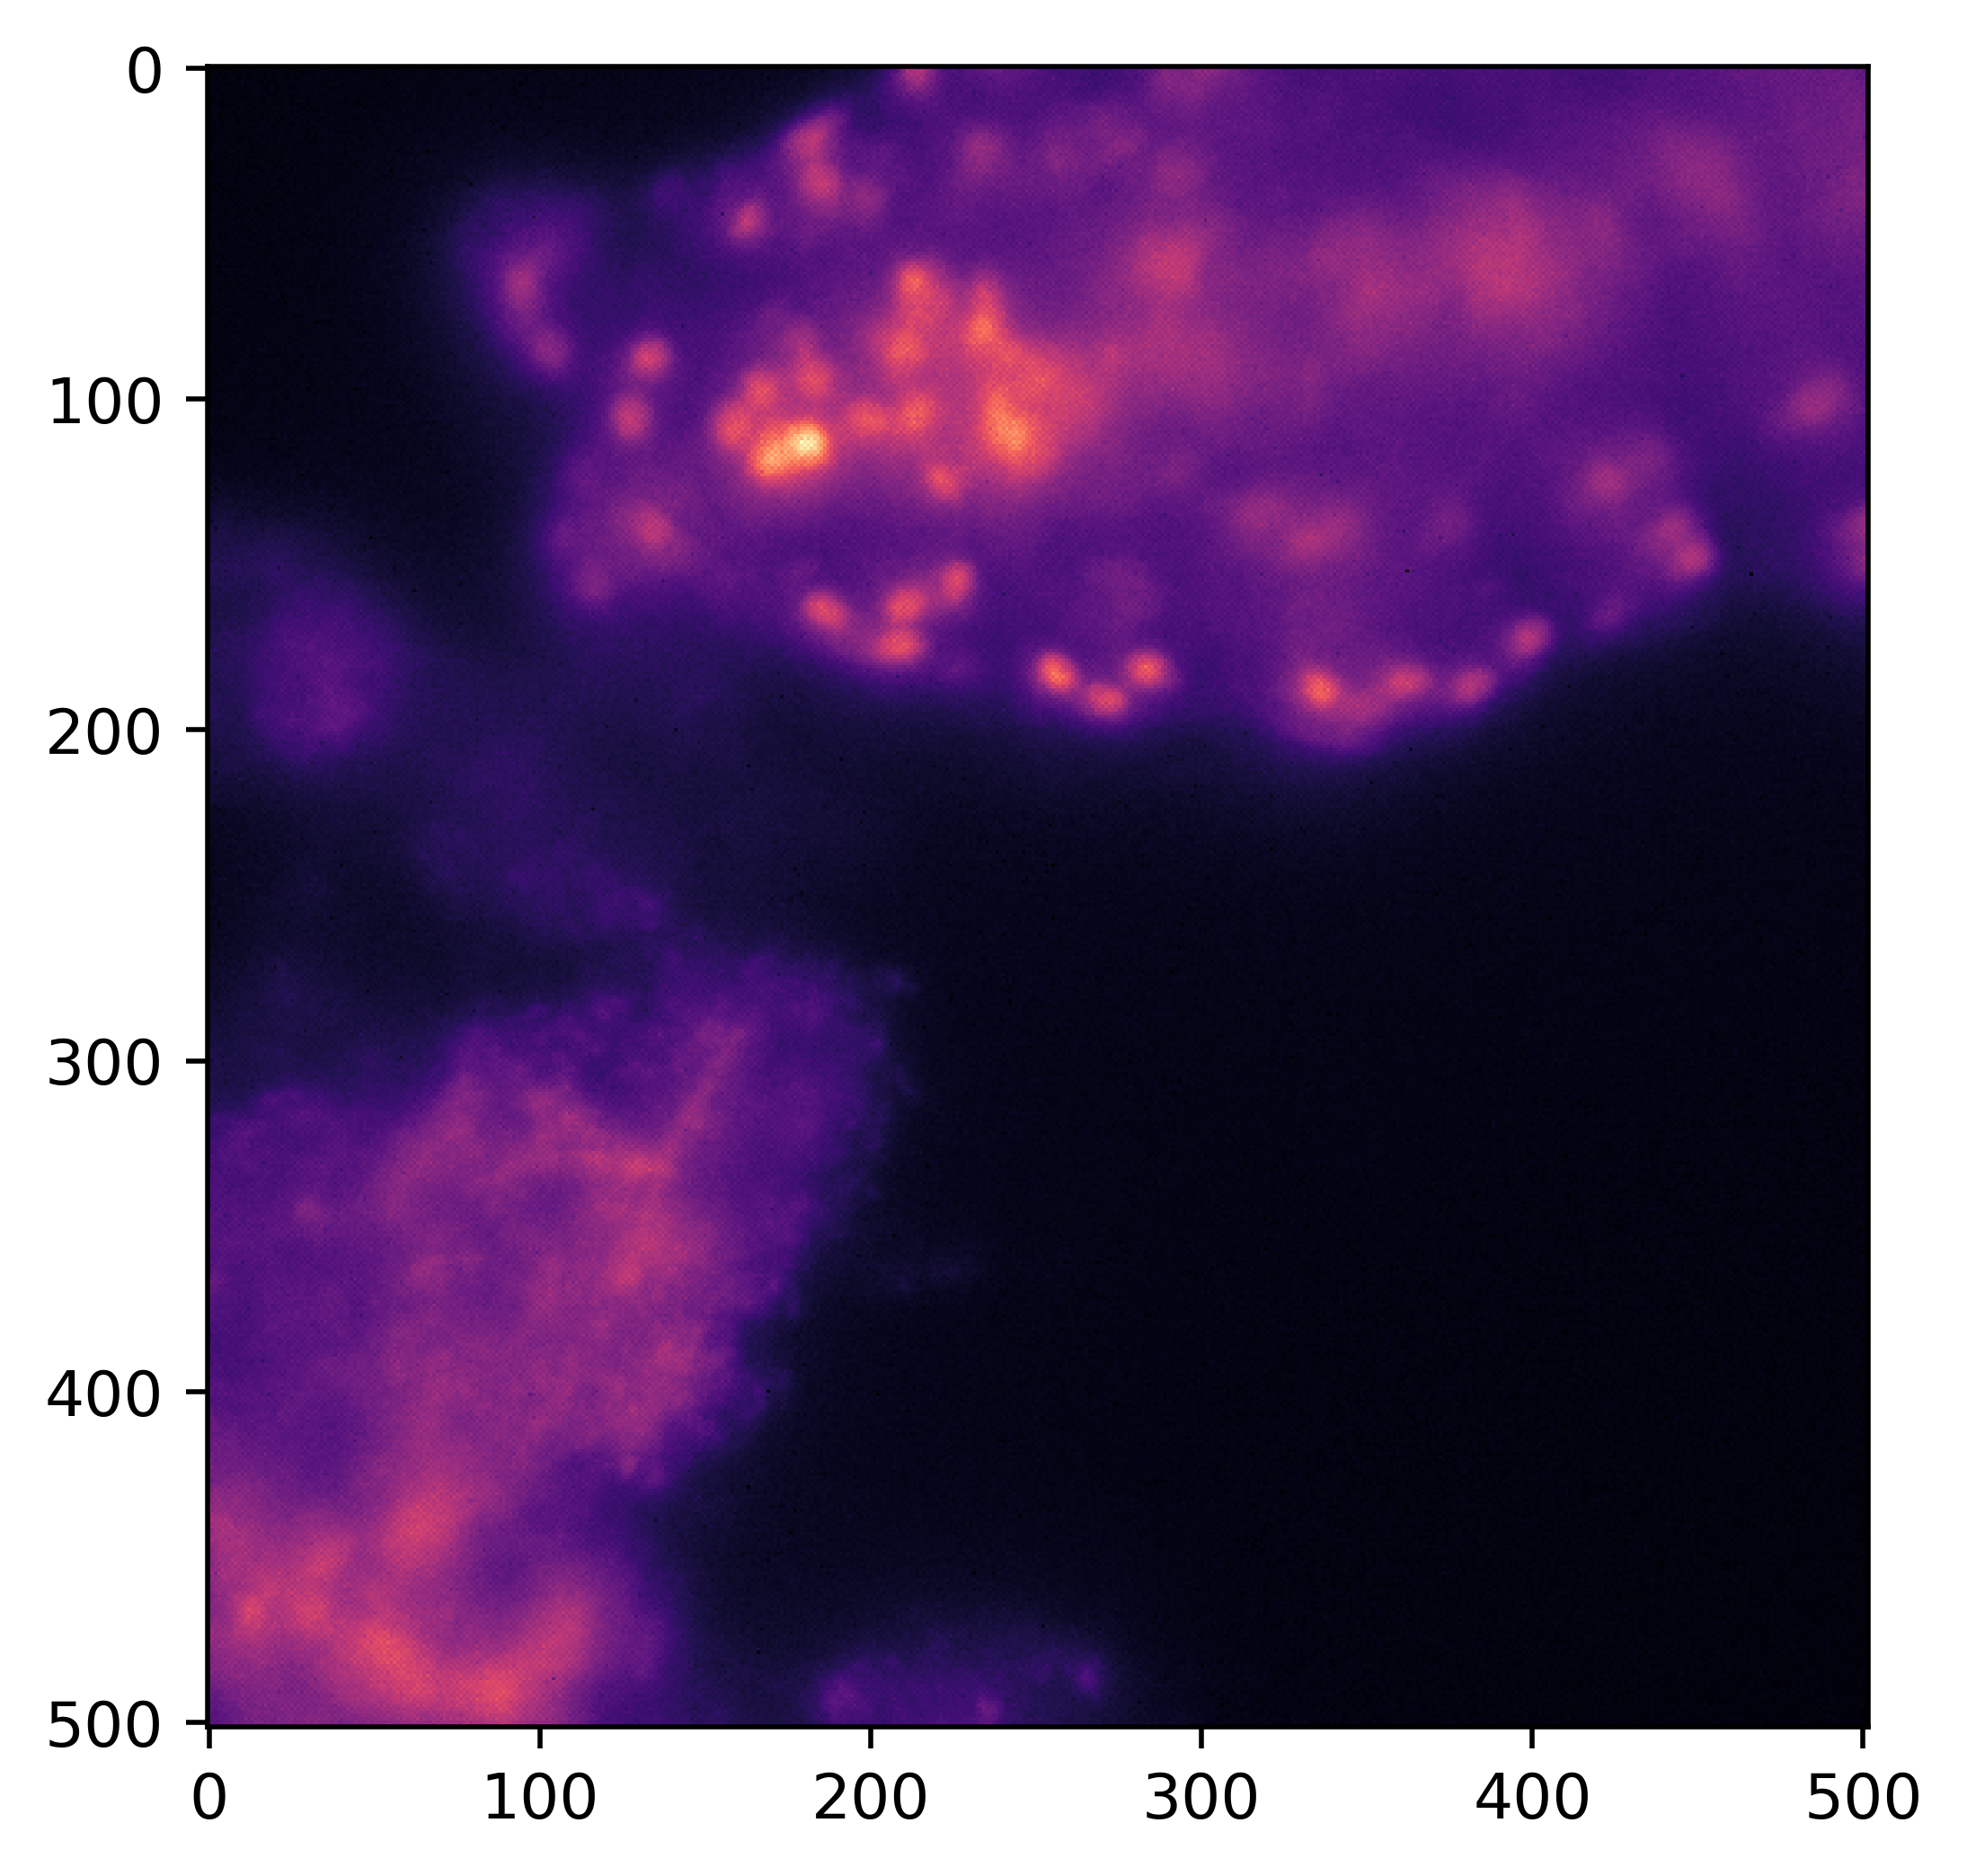

In [15]:
# Add a small crop to help with edge artifacts
c = 5

# read in the waterbear
measurement = center_crop(io.imread('test_images/measurement.png')[:,:,0], [dim,dim])
plt.imshow(crop(measurement,c), cmap='magma')
plt.show()

Now time for ring deconvolution!

100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


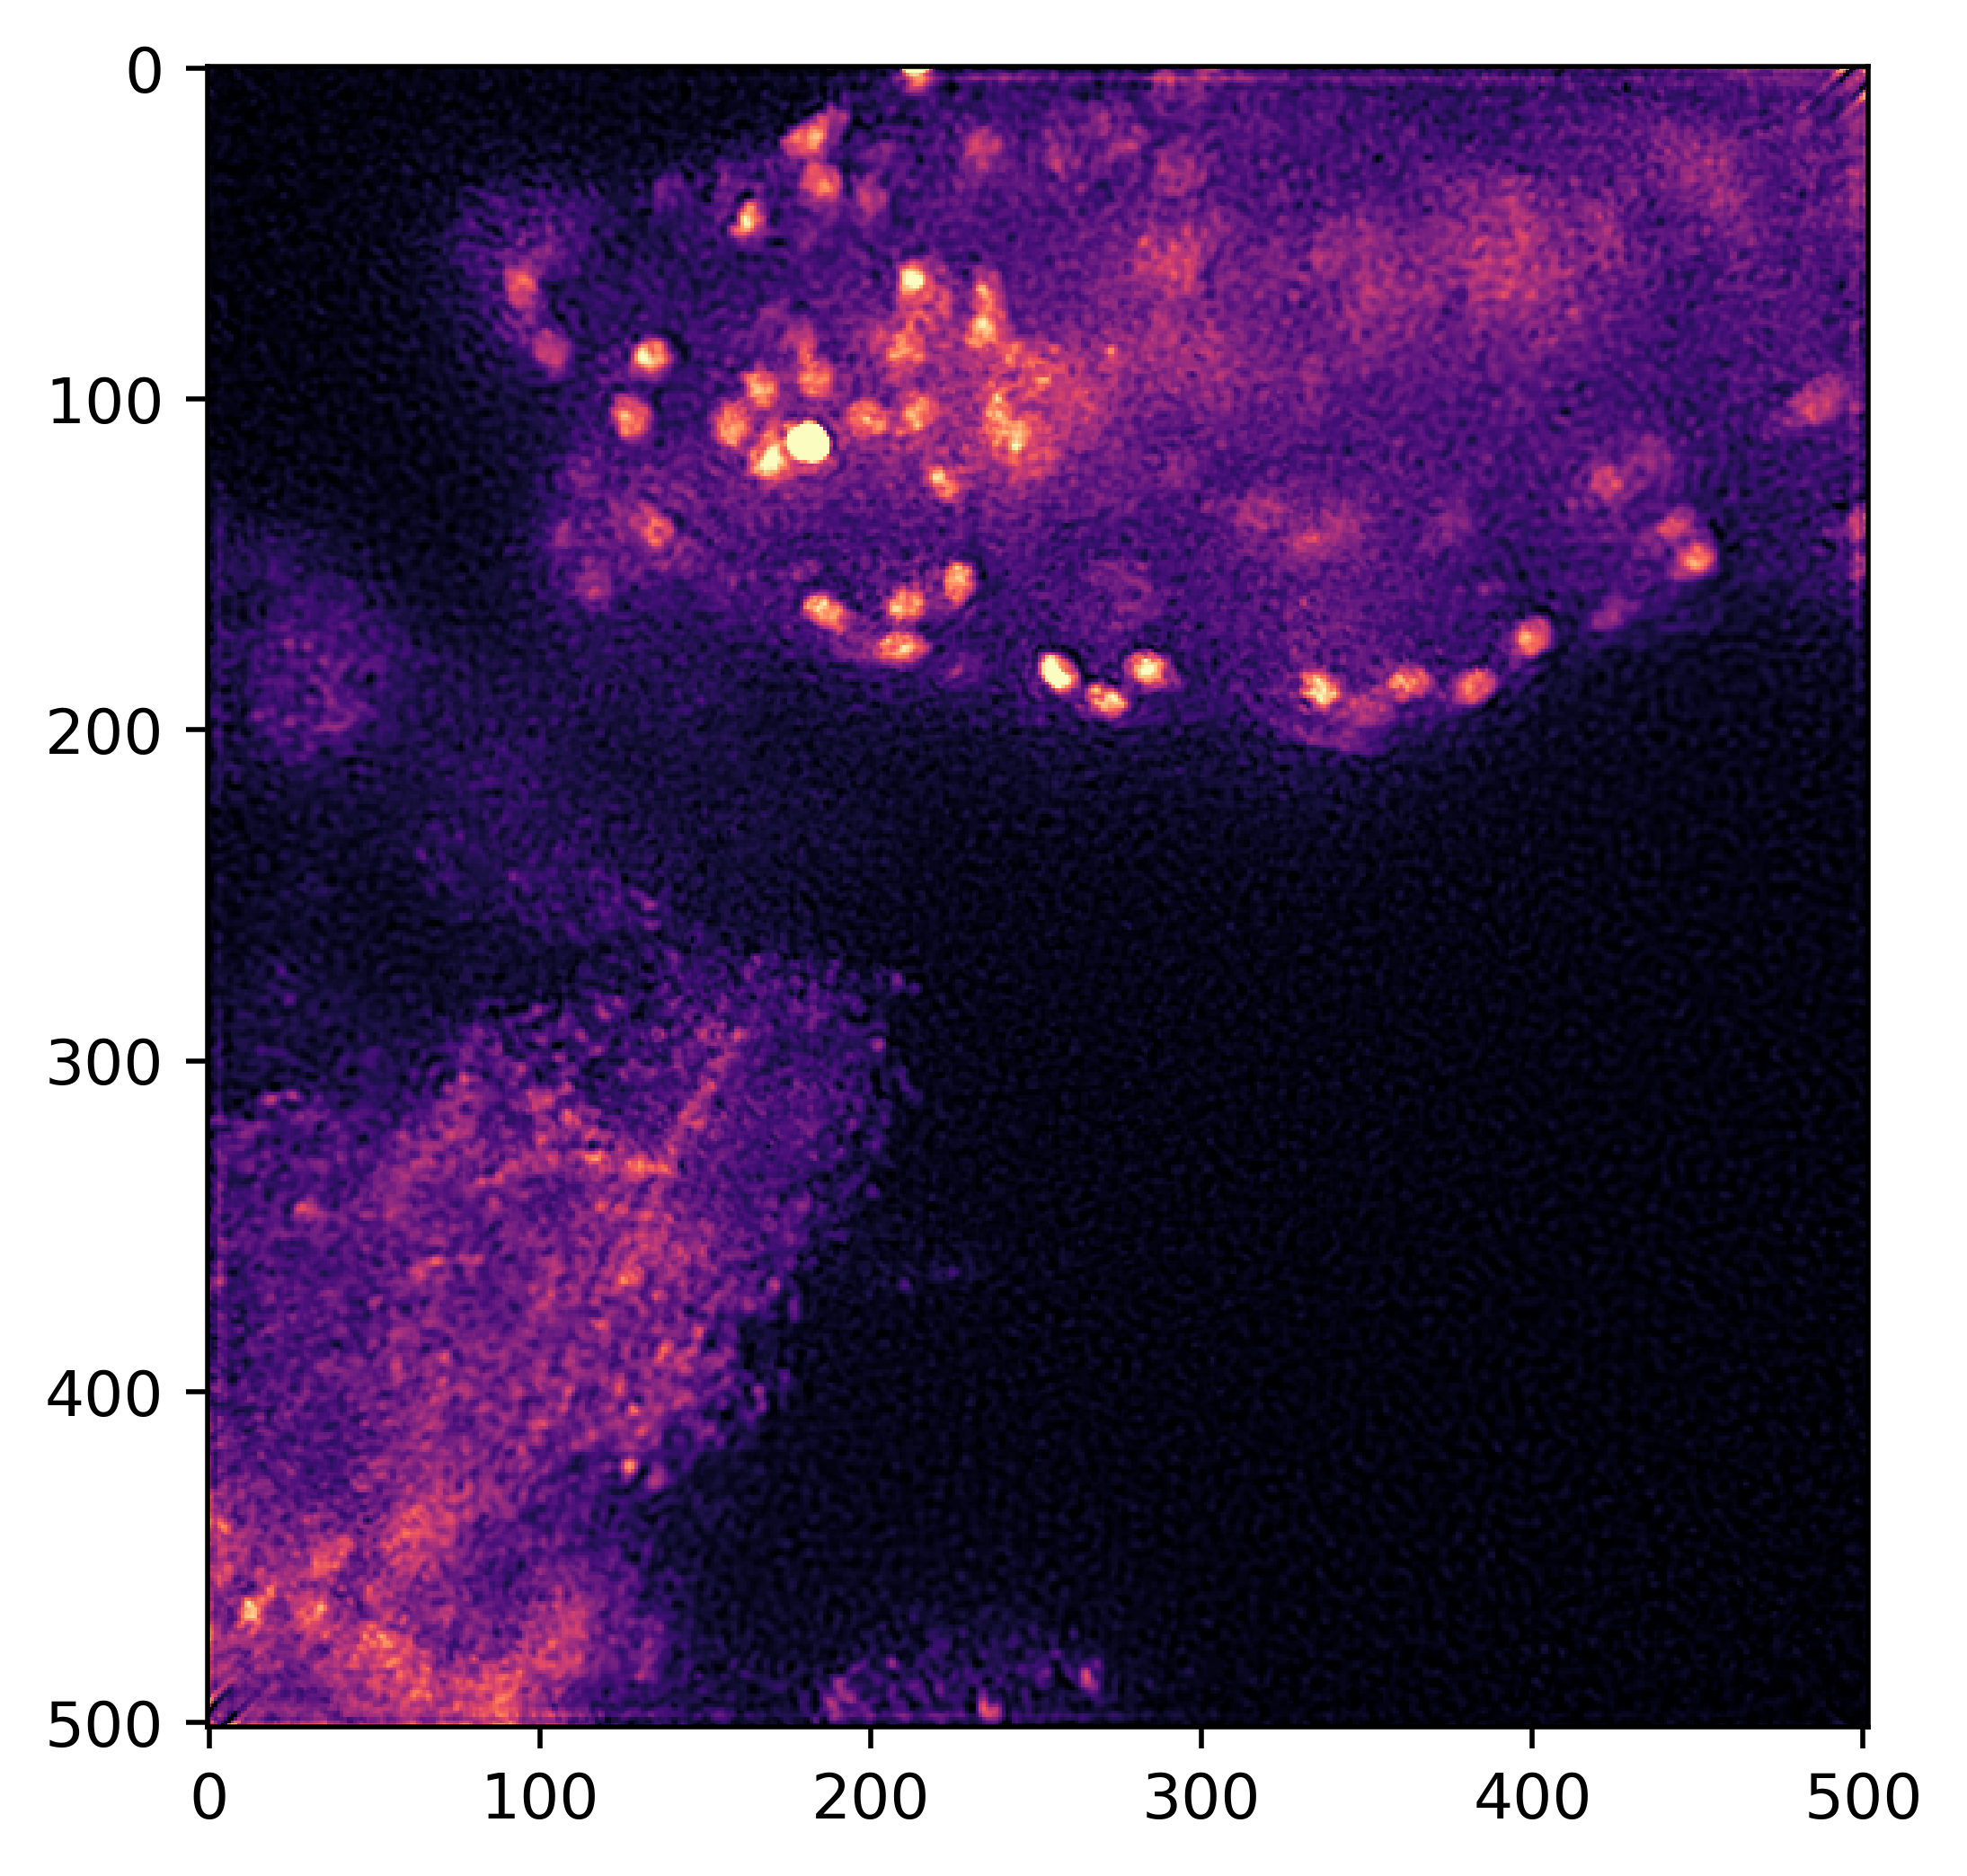

In [16]:
rd_recon = rdmpy.ring_deconvolve(measurement, psf_data, iters=200, lr=5e-2, tv_reg=1e-11, l2_reg=1e-6, opt_params={"upper_projection": True}, process=True, hot_pixel=True, device=device)
plt.imshow(crop(rd_recon,c), cmap='magma')
plt.show()

And the faster DeepRD

loading model...
rendering PSFs...


100%|██████████| 1/1 [00:00<00:00, 240.90it/s]

deblurring...


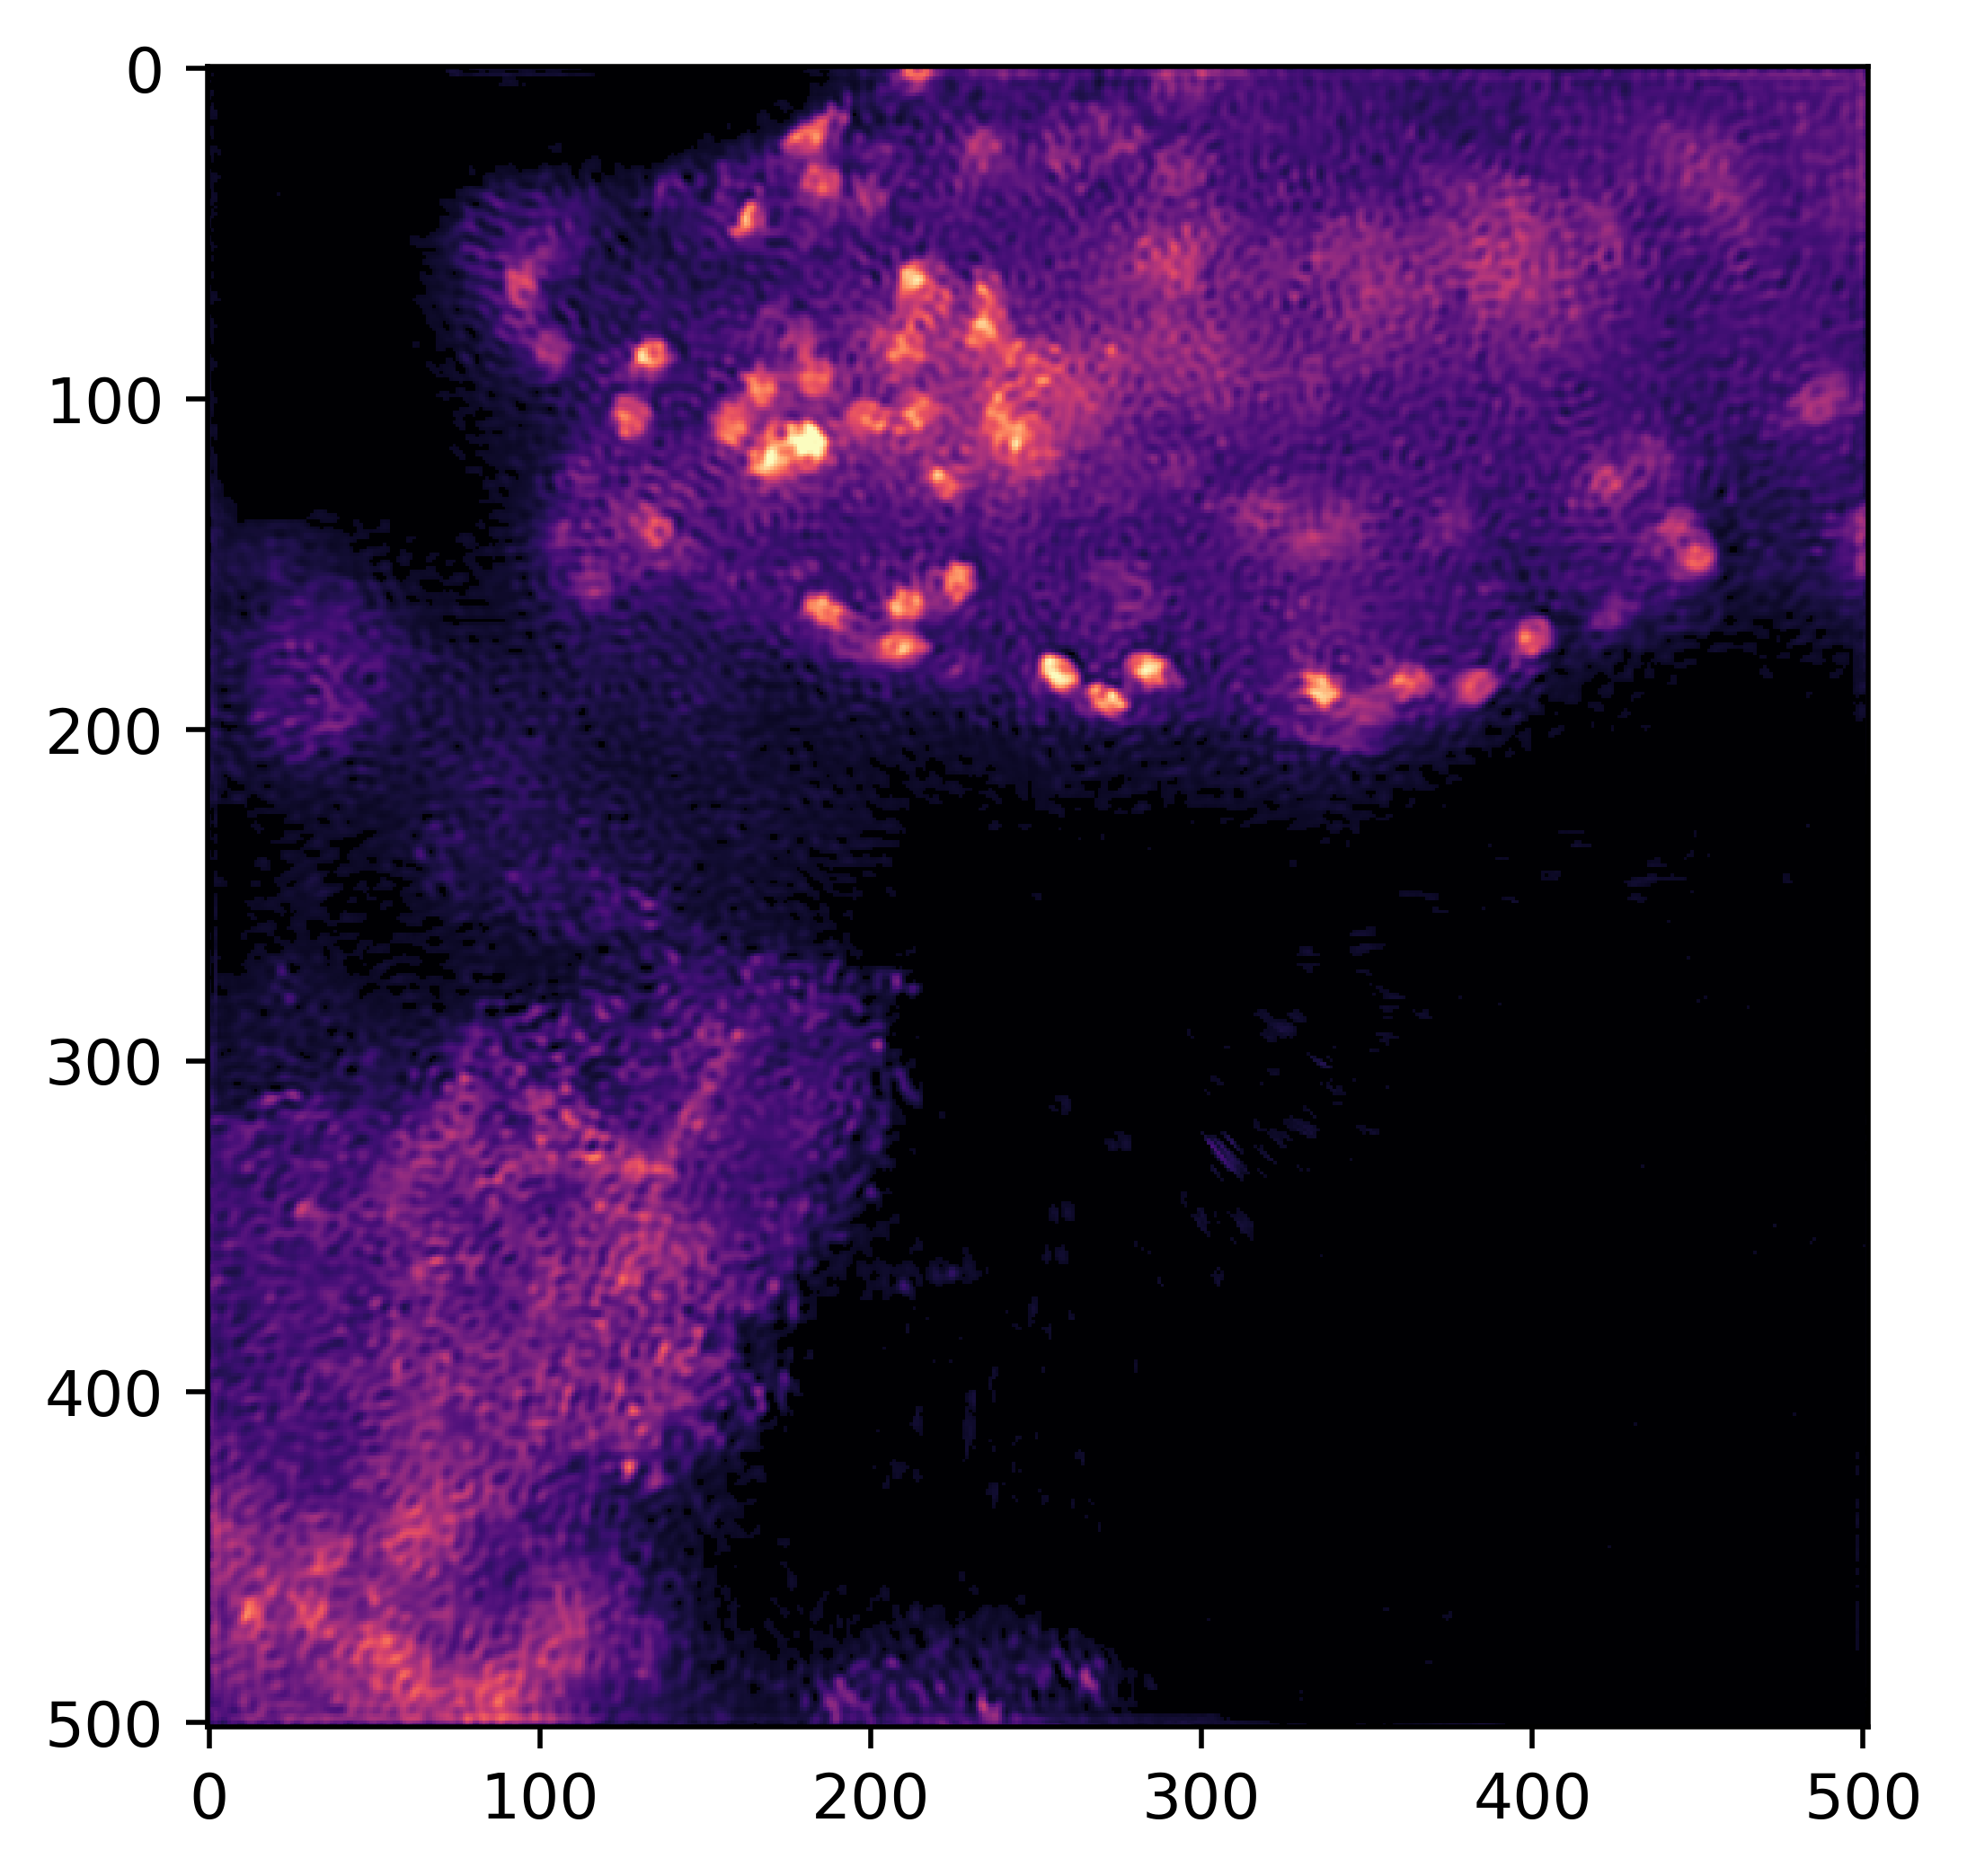

In [17]:
deeprd_recon = rdmpy.deeprd(measurement, seidel_coeffs, device=device, process=True, hot_pixel=True, noisy=0.4)
plt.imshow(crop(deeprd_recon,c), cmap='magma')
plt.show()